In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.optimize import curve_fit

## Define Functions

In [2]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267):
    absolute_consumption_loss = W-W_prime
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [3]:
## calculate abatement given a carbon price

## default settings
# P_50 = 300  # 187.5 * 0.7625000000000001
# P_100 = 500  # 187.5
# g_2019 = 0.02
# g_grad = 0.0004  # 0.00034
# W_2019 = 80
# consumption_discount = g_2019 + 0.015
# s = 0.05
# r = 0.04

## test 
P_100 = 287.5
P_50 = P_100 * 0.528125
g_2019 = 0.01
g_grad = 0.0013  # g_grad = 0.0004
W_2019 = 80
consumption_discount_adjustment = 0.015
consumption_discount = g_2019 + consumption_discount_adjustment
constraint = 5  # param_values_2[i][1]
r = consumption_discount
s = r * np.log(constraint)/np.log((P_100)/(P_50))
P0_prime = 31.33586359531034

    
# P_50 = 300  # 187.5 * 0.7625000000000001
# P_100 = 500  # 187.5
# g_2019 = 0.02
# g_grad = 0.0013 # 0.00034
# W_2019 = 80
# consumption_discount = g_2019 + 0.015
# s = 0.05
# r = 0.03
# P0_prime = 20
# # s = 0.1


def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [4]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

In [5]:
def create_W(W_2019, last_historical_year, start_year, T_forecast_years, g):
    W = []
    W_historical = [W_2019] * (last_historical_year - start_year + 1)
    W_forecast = []
    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W = W_historical + W_forecast

    W = np.asarray(W)
    return W

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [6]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

T_2019 = T_gas_df['CO2_best'][2019]

In [7]:
start_year = 1750
last_historical_year = 2019
end_year = 3000

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [8]:
delta_T = 2
alpha = 0.02
T_forecast = T_2019 + delta_T * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [9]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

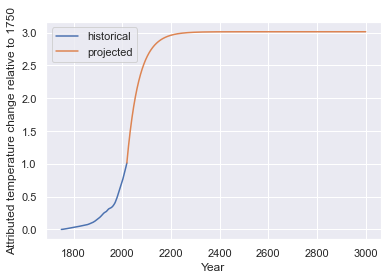

In [10]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## 2. Calculate SCC as a function of time for a range of years

In [11]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)


SCC_list = []
SCC_list_actual = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
    

    g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)**1
    g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**1
    
    growth_adjusted_consumption_discount = g_prime[j] + consumption_discount_adjustment
    

    W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
    W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)


    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-growth_adjusted_consumption_discount*(years[i]-year_of_perturbation[j]))
    
    cost = cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267)
    SCC = cost/(10**9)
    SCC_list_actual.append(SCC)
    
    if j == 0 and P0_prime > P_100:
        print("P_100 achieved in first year")
        print(SCC)
    elif j == 0:  #  and SCC > P_100
        P0 = SCC
        SCC_adjusted = SCC - (P0-P0_prime)
        SCC_list.append(P0_prime)
    else:
        SCC_adjusted = SCC - (P0-P0_prime)
        if SCC_adjusted < P_100:
            SCC_list.append(SCC_adjusted)
        else:
            SCC_list.append(P_100)
            break

In [12]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [13]:
SCC_array

array([ 31.3358636 ,  33.83148408,  36.34230013,  38.86599118,
        41.40478235,  43.95631652,  46.52287288,  49.10205738,
        51.69620381,  54.30288081,  56.92447727,  59.55852408,
        62.20746568,  64.86879479,  67.54501183,  70.23357084,
        72.93702868,  75.65280011,  78.38349892,  81.12650002,
        83.88447453,  86.6547569 ,  89.44007598,  92.23772515,
        95.0504914 ,  97.87562636, 100.71597557, 103.56874825,
       106.43684888, 109.31744354, 112.21349607, 115.12212871,
       118.04636504, 120.98328271, 123.93596546, 126.90144558,
       129.88286741, 132.8772171 , 135.88770002, 138.91125533,
       141.95114991, 145.00427516, 148.07395985, 151.15704683,
       154.25692724, 157.3703945 , 160.50090262, 163.64519476,
       166.80678829, 169.98237522, 173.17553678, 176.38291301,
       179.60814952, 182.8478335 , 186.10567544, 189.37820879,
       192.66920956, 195.97515652, 199.29989174, 202.63983846,
       205.99890542, 209.37345935, 212.7674763 , 216.17

Text(0, 0.5, 'SCC ($)')

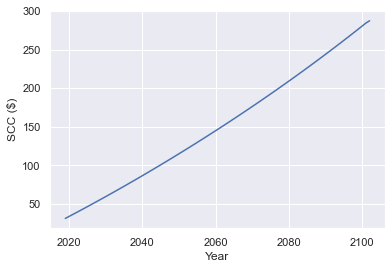

In [14]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [15]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [16]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [17]:
# SCC_forecasted

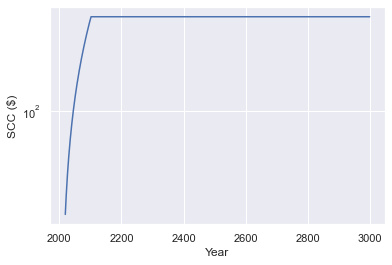

In [18]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [19]:
P0 = SCC_forecasted[0]

In [20]:
# P0

In [21]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0_prime)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_26444/3947233283.py:48: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


In [22]:
forecasted_abatement

array([0.00000000e+00, 4.84059591e-05, 2.79916850e-04, 7.82976639e-04,
       1.62757979e-03, 2.87330592e-03, 4.57561058e-03, 6.78247970e-03,
       9.54138378e-03, 1.28912915e-02, 1.68730093e-02, 2.15165790e-02,
       2.68560655e-02, 3.29119133e-02, 3.97109046e-02, 4.72630392e-02,
       5.55872072e-02, 6.46822382e-02, 7.45586804e-02, 8.52037806e-02,
       9.66196033e-02, 1.08781834e-01, 1.21684307e-01, 1.35291667e-01,
       1.49590193e-01, 1.64534508e-01, 1.80104422e-01, 1.96245993e-01,
       2.12933980e-01, 2.30107683e-01, 2.47738444e-01, 2.65760830e-01,
       2.84144494e-01, 3.02821358e-01, 3.21761088e-01, 3.40894973e-01,
       3.60194235e-01, 3.79591357e-01, 3.99060422e-01, 4.18536649e-01,
       4.37997986e-01, 4.57383607e-01, 4.76676006e-01, 4.95819177e-01,
       5.14800532e-01, 5.33569423e-01, 5.52118262e-01, 5.70401995e-01,
       5.88417889e-01, 6.06126469e-01, 6.23529525e-01, 6.40592955e-01,
       6.57322615e-01, 6.73689427e-01, 6.89702780e-01, 7.05338183e-01,
      

problems with certain values due to constraints of the model

In [23]:
((P_100-P0)/(P_50-P0))**(s/r)

6.694112957605529

Text(0, 0.5, 'Abatement')

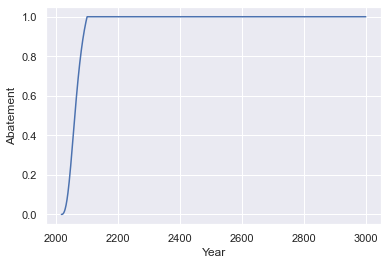

In [24]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [25]:
ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [26]:
ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [27]:
CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [28]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

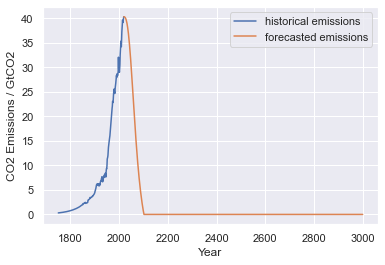

In [29]:
plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(T_forecast_years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [30]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [31]:
temperature_change = T_TCRE*cumulative_emissions_array

In [32]:
T_forecast_iteration0 = T_2019 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

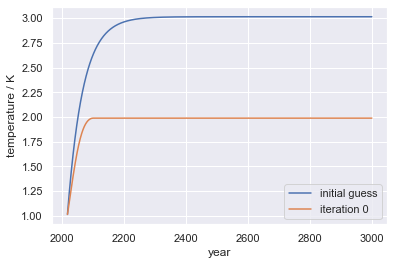

In [33]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [34]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [35]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

191.4838350862246


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_26444/3947233283.py:48: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1.9298970435041616
192.65912128892458
1.9249790040525223
1


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_26444/3947233283.py:48: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


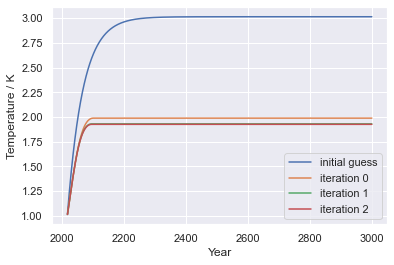

In [36]:
num_of_iterations = 99

first_perturbed_year = last_historical_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
    T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []
    SCC_list_actual = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00054  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

        T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

        g = g_2019 - g_grad*(T_forecast_iteration[:-1]-T_2019)**1
        g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**1
        
        growth_adjusted_consumption_discount = g_prime[j] + consumption_discount_adjustment
        
        W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
        W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

        ## define discount function
        num_of_years = len(years)

        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-growth_adjusted_consumption_discount*(years[i]-year_of_perturbation[j]))

        absolute_consumption_loss = W-W_prime
        discounted_consumption_loss = absolute_consumption_loss*discount_function
        area = simps(discounted_consumption_loss, dx=1)
        cost = area*10**12  # convert to dollar amount
        
        SCC = cost/(10**9)
        SCC_list_actual.append(SCC)
        
#         if SCC < P_100:
#             SCC_list.append(SCC)
#         else:
#             SCC_list.append(P_100)
#             break
        if j == 0 and P0_prime > P_100:
            print("P_100 achieved in first year")
            print(SCC)
        elif j == 0:  #  and SCC > P_100
            P0 = SCC
            print(SCC)
            SCC_list.append(P0_prime)
        else:
            SCC_adjusted = SCC - (P0-P0_prime)
            if SCC_adjusted < P_100:
                SCC_list.append(SCC_adjusted)
        #         print(SCC)
            else:
                SCC_list.append(P_100)
                break

    SCC_array = np.asarray(SCC_list)
    if SCC_array[-1] < P_100:
        print("P_100 not achieved by achieved by final perturbed year")
    SCC_forecasted = []

    for i in range(T_forecast_length):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0_prime)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE*cumulative_emissions_array
    
    T_forecast_iteration = T_2019 + temperature_change
    
    plt.plot(T_forecast_years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
        print(peak_T)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        print(peak_T)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{g_2019=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

In [37]:
P0

31.33586359531034

In [38]:
## peak Temperature
max(T_forecast_iteration)

1.9249790040525223

In [39]:
SCC_forecasted

array([ 31.3358636 ,  33.77733231,  36.25135384,  38.75598603,
        41.29376124,  43.86256402,  46.46485201,  49.09834199,
        51.76541358,  54.46360763,  57.19521802,  59.95760066,
        62.7529573 ,  65.57845269,  68.436194  ,  71.32315366,
        74.24134774,  77.18756172,  80.16373117,  83.16646758,
        86.19764428,  89.25371931,  92.33652935,  95.44240632,
        98.57318185, 101.72509418, 104.90000536, 108.09409503,
       111.30929238, 114.54175337, 117.79350938, 121.06072465,
       124.34556374, 127.64422589, 130.95903358, 134.28624091,
       137.62834585, 140.98166973, 144.34889594, 147.72641807,
       151.11710793, 154.5174298 , 157.93044095, 161.35266948,
       164.78735067, 168.23106567, 171.68721723, 175.15242634,
       178.63025096, 182.11733754, 185.61738639, 189.12705483,
       192.65017295, 196.18339494, 199.73066903, 203.28863325,
       206.86134363, 210.44541039, 214.04498842, 217.65664989,
       221.28464116, 224.92548755, 228.58352093, 232.25

In [40]:
SCC_list_actual

[192.65912128892458,
 195.1005900069595,
 197.57461153671207,
 200.0792437216185,
 202.61701893343735,
 205.18582171289918,
 207.7881097072404,
 210.421599686977,
 213.08867127789856,
 215.7868653186241,
 218.51847571562968,
 221.28085835431625,
 224.07621499413946,
 226.90171038097824,
 229.7594516944801,
 232.64641135705145,
 235.564605434943,
 238.51081940994317,
 241.48698886458646,
 244.48972527136553,
 247.52090197827994,
 250.5769770085195,
 253.65978704222226,
 256.7656640157826,
 259.896439538873,
 263.0483518708343,
 266.223263052756,
 269.41735272824906,
 272.63255007845925,
 275.86501105893103,
 279.1167670728852,
 282.38398234097565,
 285.6688214339208,
 288.9674835823146,
 292.2822912775737,
 295.60949860468594,
 298.95160354046146,
 302.30492742244206,
 305.6721536321658,
 309.04967575996056,
 312.4403656273544,
 315.8406874942964,
 319.253698647799,
 322.6759271687619,
 326.11060836410536,
 329.5543233612881,
 333.01047491994075,
 336.4756840339918,
 339.9535086549417,


hard constraint on absolute reduction that can be achieved in one year

2.013549671765545

- max ~2GtCO2 in year (look in IAMs)
- directions MACC non...
- comment on efficiency
- equation on flowchart
- balance between forcing log and errors
- gradient MACC
- table for Sobol
- peak warming and year of peak warming; scatter with growth rate